# Big data and ML - Hands-on Day 1

- course [slides](https://github.com/Course-bigDataAndML/MLCourse-INFN-2022/blob/main/Slides/Day1/Big%20data%20science%20-%20Day%201%20-%20INFN%202022.pdf)

## You'll learn

- familiarize with jupyter notebooks, numpy and pandas

### Input data
- efficient data format: convert CSV to Parquet
- create input vector with features for MLLib. Format of the input depends on chosen ML library

### Visualization
- explore dataset, plot features
- correlation matrix


## Dataset description

The dataset used in this example is described [here](https://archive.ics.uci.edu/ml/datasets/HIGGS). It is a binary classification problem where the goal is to train a classifier able to distinguish between a signal process, the production of new theoretical Higgs bosons, and a background process with identical decay products but distinct kinematic features.

Each row of this dataset contains 28 features plus the label:

- 21 low-level features which represent the basic measure made by the particle detector
 -        Momentum of the observed paricles
 -        Missing transverse momentum
 -        Jets and b-tagging information
- 7 high-level features computed from the low-level features that encode the knowledge of the different intermediate states of the two processes (reconstructed invariant masses)

# Setup the environment

Execute this cell only the first time you run the notebook. It will install necessary packages for your code to run

In [1]:
#!pip install pandas seaborn pyarrow fastparquet sklearn tensorflow 
#!pip install liboidcagent requests xmltodict boto3

Import necessary packages and functions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# our custom functions
from custom_functions import *

#### Remember to start spark by clicking on the square icon all the way to the right

Setup and restart the Spark context with our configuration

In [5]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

# get token to authenticate to minio storage
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

# build Spark configuration options    
conf = setupSpark(token)

# to update Spark config, we need first to stop the spark context
SparkContext.stop(sc)

# Then create first spark context, and then session
sc = SparkContext(conf = conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# check if Spark is there
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

# Exercise 1

## Input files - local read

- Create parquet files, which are faster to read than CSV
- Read [here](https://operational-intelligence.web.cern.ch/DataFormats) for a description of the most common data formats and their use

In [6]:
#read local CSV into a panda dataframe
%time dataset = pd.read_csv('Higgs100k.csv')

CPU times: user 788 ms, sys: 212 ms, total: 1 s
Wall time: 1.02 s


In [7]:
#remove old parquet file
!rm -rf Higgs100k.parquet

dataset.to_parquet('Higgs100k.parquet')

### Now read it back

- check that you indeed created the parquet file (ls)!
- read in the parquet file you just created (Hint: the syntax is very similar to the one above for the csv file)
- how much faster is to read parquet files rather than csv?

In [8]:
# Your code here
!ls
print(" ")
%time dataset = pd.read_parquet('Higgs100k.parquet')

custom_functions.py  inputForML.ipynb		 __pycache__
Higgs100k.csv	     inputForML_solutions.ipynb  SignalvsBackground.pdf
Higgs100k.parquet    install.sh
 
CPU times: user 92.7 ms, sys: 60.3 ms, total: 153 ms
Wall time: 135 ms


## Data from s3 object storage

- A much bigger dataset is available on the S3 object store
- Use the smallest dataset for code development
- Once your code is ready, you can try it on more events. Be aware of memory consumption and execution time!

In [9]:
#inputFile = "s3a://scratch/legger/higgs/Higgs1M.parquet"
inputFile = "s3a://scratch/legger/higgs/Higgs100k.parquet"

%time df_1M = spark.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 9.87 ms, sys: 1.96 ms, total: 11.8 ms
Wall time: 6.67 s


In [10]:
#In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(df_1M.rdd.getNumPartitions()))
print("Partitioner: {}".format(df_1M.rdd.partitioner))

Number of partitions: 2
Partitioner: None


## Explore the input dataset

Let's have a look at the input data. First we create a spark dataframe called *df*.

In [11]:
df = spark.createDataFrame(dataset)

%time total_events = df.count()

print('There are '+str(total_events)+' events')
print("ciao")

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


CPU times: user 11.4 ms, sys: 342 µs, total: 11.8 ms
Wall time: 3.95 s
There are 99999 events
ciao


In [12]:
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: 

# Exercise 2

- plot a few input variables and try to understand which ones are more promising to distinguish signal from background  

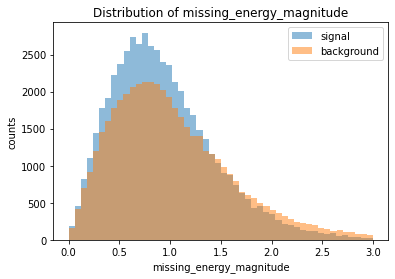

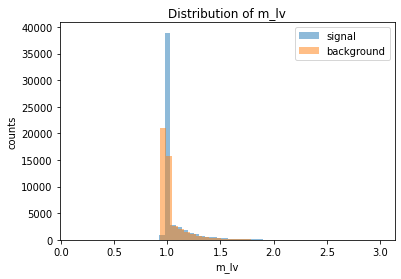

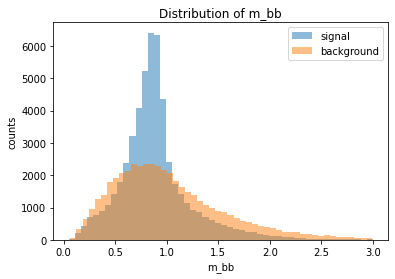

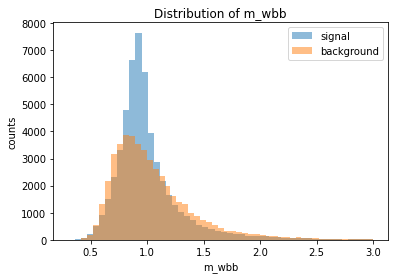

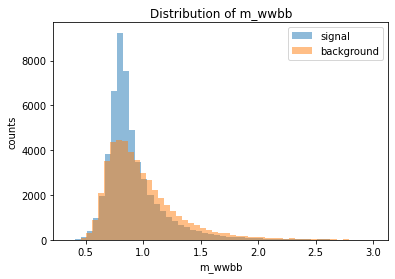

In [13]:
#plot invariant mass distribution 
plotSignalvsBg(df, 'missing_energy_magnitude')
plotSignalvsBg(df, 'm_lv') #?
plotSignalvsBg(df, 'm_bb')
plotSignalvsBg(df, 'm_wbb') 
plotSignalvsBg(df, 'm_wwbb')

# Exercise 3

#### Create the input feature vector

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe *df* a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer
- Eventually the dataframe should have the following variables:

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, **features: vector**]

In [21]:
## Your code here
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["lepton_pT", "lepton_eta", "lepton_phi", "missing_energy_magnitude", "missing_energy_phi", "jet1_pt","jet1_eta", "jet1_phi", "jet1_b-tag", "jet2_pt", "jet2_eta", "jet2_phi", "jet2_b-tag", "jet3_pt", "jet3_eta", "jet3_phi", "jet3_b-tag", "jet4_pt", "je4_eta", "jet4_phi", "jet4_b-tag", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"], 
    outputCol="features")
df1 = assembler.transform(df)
df1.printSchema()
display(df1)
df1.select('features','label','lepton_pT').take(1)


root
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: 

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

[Row(features=DenseVector([0.8693, -0.6351, 0.2257, 0.3275, -0.69, 0.7542, -0.2486, -1.0921, 0.0, 1.375, -0.6537, 0.9303, 1.1074, 1.1389, -1.5782, -1.047, 0.0, 0.6579, -0.0105, -0.0458, 3.102, 1.3538, 0.9796, 0.9781, 0.92, 0.7217, 0.9888, 0.8767]), label=1.0, lepton_pT=0.869293212890625)]